
# Lecture 7 Extension: Relative Valuation for BYD and SAIC

This notebook extends the valuation practice session with a **comparable-multiples approach** for two China automakers:

- **BYD**: valued with a **P/S (Price-to-Sales) multiple**
- **SAIC**: valued with a **P/E (Price-to-Earnings) multiple**

The goal is to learn how to move from **peer selection -> data preparation -> model construction -> valuation output** using Python, while keeping the workflow reproducible with local data files.



## Concept Review

### Why different multiples for different firms?

- **BYD (P/S)**: When margins and profitability are still changing, revenue can be a more stable anchor than current earnings.
- **SAIC (P/E)**: For a mature OEM, net income is often used as the valuation anchor for equity value (with important caveats about cyclicality and one-off items).

### Core formulas

- **Equity Value (BYD)** = Peer P/S multiple x BYD revenue
- **Equity Value (SAIC)** = Peer P/E multiple x SAIC net income

### Important cautions (we will revisit these in the results section)

- Comparable selection matters more than the arithmetic.
- Outliers (for example, Tesla) can dominate averages.
- Trailing multiples should be paired with trailing fundamentals (TTM) whenever possible.
- Cross-market valuation comparisons can be affected by investor base, listing venue, and accounting interpretation.



## Initial Data Preparation

We use three local data sources:

1. **Comparable set configuration** (peer names, tickers, and the selected multiple type)
2. **Market multiple snapshot** (captured from Yahoo Finance and saved locally for class reproducibility)
3. **China A-share profit statements** (local statement cache used to construct TTM revenue and TTM earnings)


In [1]:
# Setup: local files, helper functions, and plotting style

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 160)
pd.options.display.float_format = '{:,.4f}'.format

DATA_DIR = Path('data')
RV_DIR = DATA_DIR / 'relative_valuation_byd_saic'
CHINA_AUTO_DIR = DATA_DIR / 'china_auto'

def load_profit_sheet(symbol: str) -> pd.DataFrame:
    path = CHINA_AUTO_DIR / f'{symbol}_profit_sheet.csv.gz'
    return pd.read_csv(path, compression='gzip')

def prepare_china_income_ttm(df: pd.DataFrame) -> pd.DataFrame:
    """
    China interim income statements are typically cumulative (YTD).
    Convert cumulative values into quarterly flows, then build TTM values.
    """
    out = df.copy()
    out['report_date'] = pd.to_datetime(out['REPORT_DATE'])
    md = out['report_date'].dt.strftime('%m-%d')
    out = out[md.isin(['03-31', '06-30', '09-30', '12-31'])].copy()
    out = out.sort_values('report_date').drop_duplicates(subset=['report_date'], keep='last').reset_index(drop=True)

    for col in ['OPERATE_INCOME', 'PARENT_NETPROFIT']:
        out[col] = pd.to_numeric(out[col], errors='coerce')

    q = out[['OPERATE_INCOME', 'PARENT_NETPROFIT']].groupby(out['report_date'].dt.year).diff()
    q = q.where(~q.isna(), out[['OPERATE_INCOME', 'PARENT_NETPROFIT']])
    out['revenue_q'] = q['OPERATE_INCOME']
    out['parent_netprofit_q'] = q['PARENT_NETPROFIT']
    out['revenue_ttm'] = out['revenue_q'].rolling(4).sum()
    out['parent_netprofit_ttm'] = out['parent_netprofit_q'].rolling(4).sum()
    return out

def latest_ttm_inputs(prepared_df: pd.DataFrame) -> pd.Series:
    return prepared_df.dropna(subset=['revenue_ttm', 'parent_netprofit_ttm']).iloc[-1]

def latest_annual_inputs(prepared_df: pd.DataFrame) -> pd.Series:
    annual_rows = prepared_df[prepared_df['report_date'].dt.strftime('%m-%d') == '12-31']
    return annual_rows.iloc[-1]

def to_bn_cny(x):
    return pd.to_numeric(x, errors='coerce') / 1e9

In [2]:
# Load local comparable-set configuration and local market snapshot

comparables_cfg = pd.read_csv(RV_DIR / 'comparables_config.csv')
market_snapshot = pd.read_csv(RV_DIR / 'market_multiples_snapshot.csv')
target_map = pd.read_csv(RV_DIR / 'target_company_map.csv')

display(target_map)
display(comparables_cfg)

snapshot_cols = ['ticker', 'snapshot_date', 'currency', 'market_cap', 'trailing_pe', 'price_to_sales_ttm']
display(market_snapshot[snapshot_cols].sort_values('ticker'))

,target,ticker,market,valuation_multiple_used
0,BYD,002594.SZ,SZSE A-share,PS
1,SAIC,600104.SS,SSE A-share,PE


,target,peer_name,ticker,selected_multiple,rationale
0,BYD,Tesla,TSLA,PS,"EV-focused, vertically integrated, global scale"
1,BYD,Geely Auto,GELYF,PS,Rapid electrification transition within China
2,BYD,Li Auto,LI,PS,"Similar growth trajectory, expansion phase"
3,BYD,NIO,NIO,PS,"EV exposure, but different scale and profitabi..."
4,SAIC,Volkswagen Group,VWAGY,PE,Diversified global OEM with ICE + EV
5,SAIC,General Motors,GM,PE,Mature OEM with JV and transition exposure
6,SAIC,Toyota Motor,TM,PE,Large-scale global incumbent
7,SAIC,Hyundai Motor,HYMLF,PE,Asian multinational OEM


,ticker,snapshot_date,currency,market_cap,trailing_pe,price_to_sales_ttm
0,002594.SZ,2026-02-25,CNY,858499448832,66.3237,1.0207
1,600104.SS,2026-02-25,CNY,167371243520,58.2400,0.2513
2,GELYF,2026-02-25,USD,23385610240,10.2857,0.0806
3,GM,2026-02-25,USD,75832295424,24.4114,0.4099
4,HYMLF,2026-02-25,USD,43904856064,6.3183,NaN
5,LI,2026-02-25,USD,18918017024,16.9727,0.1480
6,NIO,2026-02-25,USD,13401893888,NaN,0.1848
7,TM,2026-02-25,USD,311041785856,12.9344,0.0062
8,TSLA,2026-02-25,USD,1536170524672,368.8108,16.1997
9,VWAGY,2026-02-25,USD,60255690752,7.6076,0.1848



### Build target-company valuation denominators from local statements (TTM)

To match trailing market multiples more closely, we estimate **TTM revenue** and **TTM parent net profit** from local China A-share cumulative income statements.


In [3]:
# BYD and SAIC profit statements -> quarterly flows -> TTM values

byd_profit_raw = load_profit_sheet('sz002594')
saic_profit_raw = load_profit_sheet('sh600104')

byd_income = prepare_china_income_ttm(byd_profit_raw)
saic_income = prepare_china_income_ttm(saic_profit_raw)

byd_ttm = latest_ttm_inputs(byd_income)
saic_ttm = latest_ttm_inputs(saic_income)

byd_annual = latest_annual_inputs(byd_income)
saic_annual = latest_annual_inputs(saic_income)

# Optional context: SAIC earnings can be cyclical; a simple normalized anchor is the recent 3-year annual average.
saic_annual_hist = saic_income[saic_income['report_date'].dt.strftime('%m-%d') == '12-31'].copy()
saic_annual_hist = saic_annual_hist.sort_values('report_date')
saic_parent_np_3y_avg_bn = to_bn_cny(saic_annual_hist['PARENT_NETPROFIT'].tail(3)).mean()

target_inputs = pd.DataFrame([
    {
        'target': 'BYD',
        'ticker': '002594.SZ',
        'ttm_report_date': byd_ttm['report_date'].date(),
        'ttm_revenue_bn_cny': to_bn_cny(byd_ttm['revenue_ttm']),
        'ttm_parent_netprofit_bn_cny': to_bn_cny(byd_ttm['parent_netprofit_ttm']),
        'latest_audited_annual_date': byd_annual['report_date'].date(),
        'latest_audited_revenue_bn_cny': to_bn_cny(byd_annual['OPERATE_INCOME']),
        'latest_audited_parent_netprofit_bn_cny': to_bn_cny(byd_annual['PARENT_NETPROFIT']),
    },
    {
        'target': 'SAIC',
        'ticker': '600104.SS',
        'ttm_report_date': saic_ttm['report_date'].date(),
        'ttm_revenue_bn_cny': to_bn_cny(saic_ttm['revenue_ttm']),
        'ttm_parent_netprofit_bn_cny': to_bn_cny(saic_ttm['parent_netprofit_ttm']),
        'latest_audited_annual_date': saic_annual['report_date'].date(),
        'latest_audited_revenue_bn_cny': to_bn_cny(saic_annual['OPERATE_INCOME']),
        'latest_audited_parent_netprofit_bn_cny': to_bn_cny(saic_annual['PARENT_NETPROFIT']),
        'saic_3y_avg_annual_parent_netprofit_bn_cny': saic_parent_np_3y_avg_bn,
    },
])

display(target_inputs)

# Short look at the last few observations used to form TTM (helps students see the cumulative->quarterly conversion)
display(byd_income[['report_date', 'REPORT_DATE_NAME', 'revenue_q', 'parent_netprofit_q', 'revenue_ttm', 'parent_netprofit_ttm']].tail(6))
display(saic_income[['report_date', 'REPORT_DATE_NAME', 'revenue_q', 'parent_netprofit_q', 'revenue_ttm', 'parent_netprofit_ttm']].tail(6))

,target,ticker,ttm_report_date,ttm_revenue_bn_cny,ttm_parent_netprofit_bn_cny,latest_audited_annual_date,latest_audited_revenue_bn_cny,latest_audited_parent_netprofit_bn_cny,saic_3y_avg_annual_parent_netprofit_bn_cny
0,BYD,002594.SZ,2025-09-30,841.1167,38.3494,2024-12-31,777.1025,40.2543,NaN
1,SAIC,600104.SS,2025-09-30,655.6519,2.8598,2024-12-31,614.0741,1.6664,10.6300


,report_date,REPORT_DATE_NAME,revenue_q,parent_netprofit_q,revenue_ttm,parent_netprofit_ttm
65,2024-06-30,2024中报,"176,182,316,000.0000","9,062,464,000.0000","643,317,924,000.0000","32,717,923,000.0000"
66,2024-09-30,2024三季报,"201,124,599,000.0000","11,606,858,000.0000","682,291,828,000.0000","33,912,030,000.0000"
67,2024-12-31,2024年报,"274,851,143,000.0000","15,016,231,000.0000","777,102,455,000.0000","40,254,346,000.0000"
68,2025-03-31,2025一季报,"170,360,448,000.0000","9,154,985,000.0000","822,518,506,000.0000","44,840,538,000.0000"
69,2025-06-30,2025中报,"200,920,500,000.0000","6,355,548,000.0000","847,256,690,000.0000","42,133,622,000.0000"
70,2025-09-30,2025三季报,"194,984,598,000.0000","7,822,640,000.0000","841,116,689,000.0000","38,349,404,000.0000"


,report_date,REPORT_DATE_NAME,revenue_q,parent_netprofit_q,revenue_ttm,parent_netprofit_ttm
102,2024-06-30,2024中报,"138,101,674,289.8900","3,913,953,589.0000","686,875,095,089.3101","13,648,858,748.2800"
103,2024-09-30,2024三季报,"142,560,534,690.7900","279,690,120.6000","637,875,167,982.8400","9,606,356,803.7100"
104,2024-12-31,2024年报,"194,427,995,485.1500","-5,241,052,975.5600","614,074,061,818.1300","1,666,376,761.0700"
105,2025-03-31,2025一季报,"137,680,076,791.8300","3,023,194,058.7600","612,770,281,257.6600","1,975,784,792.8000"
106,2025-06-30,2025中报,"156,656,193,797.6900","2,994,316,014.3600","631,324,800,765.4600","1,056,147,218.1600"
107,2025-09-30,2025三季报,"166,887,589,399.9900","2,083,357,266.6700","655,651,855,474.6600","2,859,814,364.2300"



## Model Building

We now combine:

- peer multiple snapshots (dimensionless)
- target-company TTM fundamentals (CNY bn)

to estimate implied **equity value (market capitalization)** in **CNY bn**.



### BYD Relative Valuation (P/S)

BYD is valued using peer **P/S** multiples. Because Tesla is often an outlier in EV valuation, we compare multiple summary statistics instead of relying on a single average.


In [4]:
# BYD: peer P/S multiples -> implied equity value (CNY bn)

byd_cfg = comparables_cfg[comparables_cfg['target'] == 'BYD'].copy()
byd_peers = byd_cfg.merge(market_snapshot, on='ticker', how='left')
byd_peers['ps_ratio'] = pd.to_numeric(byd_peers['price_to_sales_ttm'], errors='coerce')

display(byd_peers[['peer_name', 'ticker', 'ps_ratio', 'currency', 'snapshot_date', 'rationale']])

byd_revenue_ttm_bn = float(target_inputs.loc[target_inputs['target'] == 'BYD', 'ttm_revenue_bn_cny'].iloc[0])
byd_actual_mcap_bn = float(market_snapshot.loc[market_snapshot['ticker'] == '002594.SZ', 'market_cap'].iloc[0]) / 1e9

byd_ps_values = byd_peers['ps_ratio'].dropna()
byd_ps_ex_tesla = byd_peers.loc[byd_peers['peer_name'] != 'Tesla', 'ps_ratio'].dropna()

byd_ps_scenarios = pd.DataFrame([
    {'scenario': 'Peer Mean (all peers)', 'multiple': byd_ps_values.mean()},
    {'scenario': 'Peer Median (all peers)', 'multiple': byd_ps_values.median()},
    {'scenario': 'Peer Mean (ex-Tesla)', 'multiple': byd_ps_ex_tesla.mean()},
    {'scenario': '25th Percentile', 'multiple': byd_ps_values.quantile(0.25)},
    {'scenario': '75th Percentile', 'multiple': byd_ps_values.quantile(0.75)},
])
byd_ps_scenarios['target_revenue_ttm_bn_cny'] = byd_revenue_ttm_bn
byd_ps_scenarios['implied_equity_value_bn_cny'] = byd_ps_scenarios['multiple'] * byd_ps_scenarios['target_revenue_ttm_bn_cny']
byd_ps_scenarios['actual_market_cap_bn_cny'] = byd_actual_mcap_bn
byd_ps_scenarios['premium_discount_vs_actual_%'] = (
    byd_ps_scenarios['implied_equity_value_bn_cny'] / byd_actual_mcap_bn - 1
) * 100

display(byd_ps_scenarios.round(3))

,peer_name,ticker,ps_ratio,currency,snapshot_date,rationale
0,Tesla,TSLA,16.1997,USD,2026-02-25,"EV-focused, vertically integrated, global scale"
1,Geely Auto,GELYF,0.0806,USD,2026-02-25,Rapid electrification transition within China
2,Li Auto,LI,0.1480,USD,2026-02-25,"Similar growth trajectory, expansion phase"
3,NIO,NIO,0.1848,USD,2026-02-25,"EV exposure, but different scale and profitabi..."


,scenario,multiple,target_revenue_ttm_bn_cny,implied_equity_value_bn_cny,actual_market_cap_bn_cny,premium_discount_vs_actual_%
0,Peer Mean (all peers),4.1530,841.1170,"3,493.3860",858.4990,306.9180
1,Peer Median (all peers),0.1660,841.1170,139.9470,858.4990,-83.6990
2,Peer Mean (ex-Tesla),0.1380,841.1170,115.8970,858.4990,-86.5000
3,25th Percentile,0.1310,841.1170,110.3230,858.4990,-87.1490
4,75th Percentile,4.1880,841.1170,"3,523.0100",858.4990,310.3680



### SAIC Relative Valuation (P/E)

SAIC is valued using peer **P/E** multiples. We first use **TTM parent net profit** (to align with trailing P/E), then add a simple normalized earnings view using the recent 3-year annual average.


In [5]:
# SAIC: peer P/E multiples -> implied equity value (CNY bn)

saic_cfg = comparables_cfg[comparables_cfg['target'] == 'SAIC'].copy()
saic_peers = saic_cfg.merge(market_snapshot, on='ticker', how='left')
saic_peers['pe_ratio'] = pd.to_numeric(saic_peers['trailing_pe'], errors='coerce')

display(saic_peers[['peer_name', 'ticker', 'pe_ratio', 'currency', 'snapshot_date', 'rationale']])

saic_np_ttm_bn = float(target_inputs.loc[target_inputs['target'] == 'SAIC', 'ttm_parent_netprofit_bn_cny'].iloc[0])
saic_np_norm_bn = float(target_inputs.loc[target_inputs['target'] == 'SAIC', 'saic_3y_avg_annual_parent_netprofit_bn_cny'].iloc[0])
saic_actual_mcap_bn = float(market_snapshot.loc[market_snapshot['ticker'] == '600104.SS', 'market_cap'].iloc[0]) / 1e9

saic_pe_values = saic_peers['pe_ratio'].dropna()
saic_pe_stats = {
    'Peer Mean': saic_pe_values.mean(),
    'Peer Median': saic_pe_values.median(),
    '25th Percentile': saic_pe_values.quantile(0.25),
    '75th Percentile': saic_pe_values.quantile(0.75),
}

saic_base = pd.DataFrame([
    {
        'scenario': name,
        'multiple': value,
        'earnings_anchor': 'SAIC TTM parent net profit',
        'earnings_bn_cny': saic_np_ttm_bn,
    }
    for name, value in saic_pe_stats.items()
])

saic_norm = pd.DataFrame([
    {
        'scenario': 'Peer Median (Normalized Earnings)',
        'multiple': saic_pe_stats['Peer Median'],
        'earnings_anchor': 'SAIC 3Y average annual parent net profit',
        'earnings_bn_cny': saic_np_norm_bn,
    }
])

saic_pe_scenarios = pd.concat([saic_base, saic_norm], ignore_index=True)
saic_pe_scenarios['implied_equity_value_bn_cny'] = saic_pe_scenarios['multiple'] * saic_pe_scenarios['earnings_bn_cny']
saic_pe_scenarios['actual_market_cap_bn_cny'] = saic_actual_mcap_bn
saic_pe_scenarios['premium_discount_vs_actual_%'] = (
    saic_pe_scenarios['implied_equity_value_bn_cny'] / saic_actual_mcap_bn - 1
) * 100

display(saic_pe_scenarios.round(3))

,peer_name,ticker,pe_ratio,currency,snapshot_date,rationale
0,Volkswagen Group,VWAGY,7.6076,USD,2026-02-25,Diversified global OEM with ICE + EV
1,General Motors,GM,24.4114,USD,2026-02-25,Mature OEM with JV and transition exposure
2,Toyota Motor,TM,12.9344,USD,2026-02-25,Large-scale global incumbent
3,Hyundai Motor,HYMLF,6.3183,USD,2026-02-25,Asian multinational OEM


,scenario,multiple,earnings_anchor,earnings_bn_cny,implied_equity_value_bn_cny,actual_market_cap_bn_cny,premium_discount_vs_actual_%
0,Peer Mean,12.8180,SAIC TTM parent net profit,2.8600,36.6570,167.3710,-78.0980
1,Peer Median,10.2710,SAIC TTM parent net profit,2.8600,29.3730,167.3710,-82.4500
2,25th Percentile,7.2850,SAIC TTM parent net profit,2.8600,20.8350,167.3710,-87.5520
3,75th Percentile,15.8040,SAIC TTM parent net profit,2.8600,45.1960,167.3710,-72.9970
4,Peer Median (Normalized Earnings),10.2710,SAIC 3Y average annual parent net profit,10.6300,109.1810,167.3710,-34.7670



## Results Display

We summarize the comparable-multiple valuation outputs and compare them with current market capitalization (from the local snapshot).


In [6]:
# Build a compact teaching summary table

summary_rows = []

for _, row in byd_ps_scenarios.iterrows():
    summary_rows.append({
        'target': 'BYD',
        'method': 'P/S',
        'scenario': row['scenario'],
        'multiple': row['multiple'],
        'denominator_used': 'TTM revenue',
        'denominator_bn_cny': row['target_revenue_ttm_bn_cny'],
        'implied_equity_value_bn_cny': row['implied_equity_value_bn_cny'],
        'actual_market_cap_bn_cny': row['actual_market_cap_bn_cny'],
        'premium_discount_vs_actual_%': row['premium_discount_vs_actual_%'],
    })

for _, row in saic_pe_scenarios.iterrows():
    summary_rows.append({
        'target': 'SAIC',
        'method': 'P/E',
        'scenario': row['scenario'],
        'multiple': row['multiple'],
        'denominator_used': row['earnings_anchor'],
        'denominator_bn_cny': row['earnings_bn_cny'],
        'implied_equity_value_bn_cny': row['implied_equity_value_bn_cny'],
        'actual_market_cap_bn_cny': row['actual_market_cap_bn_cny'],
        'premium_discount_vs_actual_%': row['premium_discount_vs_actual_%'],
    })

valuation_summary = pd.DataFrame(summary_rows)
display(valuation_summary.round(3))

,target,method,scenario,multiple,denominator_used,denominator_bn_cny,implied_equity_value_bn_cny,actual_market_cap_bn_cny,premium_discount_vs_actual_%
0,BYD,P/S,Peer Mean (all peers),4.1530,TTM revenue,841.1170,"3,493.3860",858.4990,306.9180
1,BYD,P/S,Peer Median (all peers),0.1660,TTM revenue,841.1170,139.9470,858.4990,-83.6990
2,BYD,P/S,Peer Mean (ex-Tesla),0.1380,TTM revenue,841.1170,115.8970,858.4990,-86.5000
3,BYD,P/S,25th Percentile,0.1310,TTM revenue,841.1170,110.3230,858.4990,-87.1490
4,BYD,P/S,75th Percentile,4.1880,TTM revenue,841.1170,"3,523.0100",858.4990,310.3680
5,SAIC,P/E,Peer Mean,12.8180,SAIC TTM parent net profit,2.8600,36.6570,167.3710,-78.0980
6,SAIC,P/E,Peer Median,10.2710,SAIC TTM parent net profit,2.8600,29.3730,167.3710,-82.4500
7,SAIC,P/E,25th Percentile,7.2850,SAIC TTM parent net profit,2.8600,20.8350,167.3710,-87.5520
8,SAIC,P/E,75th Percentile,15.8040,SAIC TTM parent net profit,2.8600,45.1960,167.3710,-72.9970
9,SAIC,P/E,Peer Median (Normalized Earnings),10.2710,SAIC 3Y average annual parent net profit,10.6300,109.1810,167.3710,-34.7670


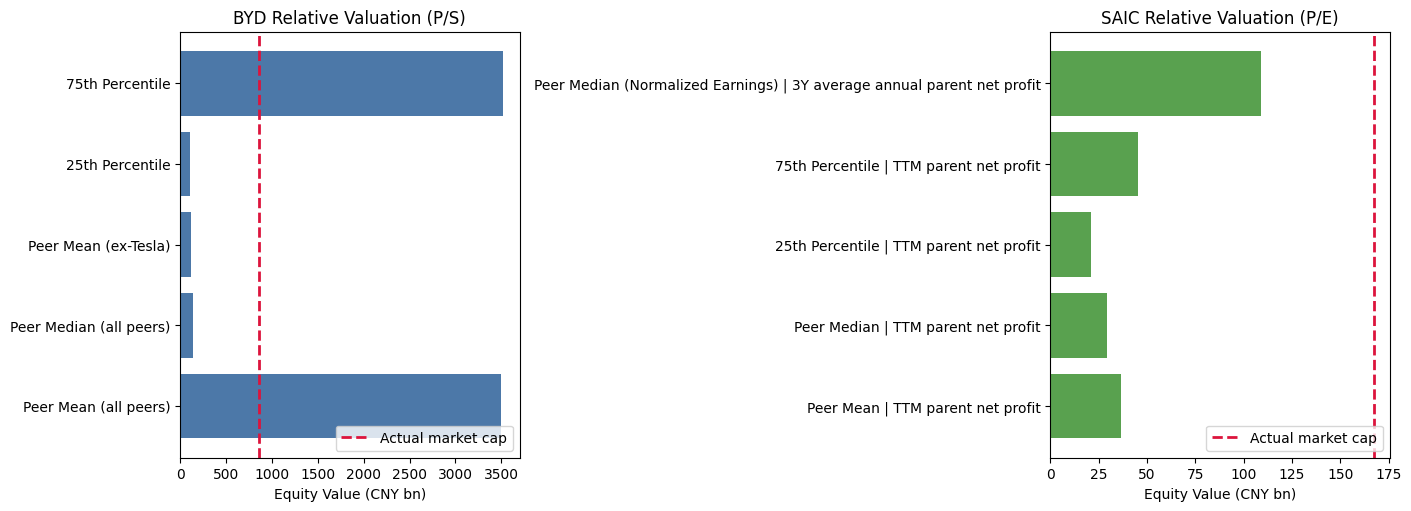

In [7]:
# Visualization: implied equity value vs actual market cap (CNY bn)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

# BYD plot
byd_plot = byd_ps_scenarios[['scenario', 'implied_equity_value_bn_cny']].copy()
axes[0].barh(byd_plot['scenario'], byd_plot['implied_equity_value_bn_cny'], color='#4C78A8')
axes[0].axvline(byd_actual_mcap_bn, color='crimson', linestyle='--', linewidth=2, label='Actual market cap')
axes[0].set_title('BYD Relative Valuation (P/S)')
axes[0].set_xlabel('Equity Value (CNY bn)')
axes[0].legend(loc='lower right')

# SAIC plot
saic_plot = saic_pe_scenarios[['scenario', 'earnings_anchor', 'implied_equity_value_bn_cny']].copy()
saic_plot['label'] = saic_plot['scenario'] + ' | ' + saic_plot['earnings_anchor'].str.replace('SAIC ', '', regex=False)
axes[1].barh(saic_plot['label'], saic_plot['implied_equity_value_bn_cny'], color='#59A14F')
axes[1].axvline(saic_actual_mcap_bn, color='crimson', linestyle='--', linewidth=2, label='Actual market cap')
axes[1].set_title('SAIC Relative Valuation (P/E)')
axes[1].set_xlabel('Equity Value (CNY bn)')
axes[1].legend(loc='lower right')

plt.show()


### Interpreting the output

- **BYD (P/S)**: the result changes dramatically depending on whether Tesla is included and how we summarize peer multiples. This is a useful lesson on **outlier sensitivity**.
- **SAIC (P/E)**: the TTM-based valuation may differ sharply from market capitalization if current earnings are temporarily depressed (or elevated). A normalized earnings anchor can change the conclusion.
- **Practical takeaway**: relative valuation is fast and intuitive, but it is only as good as the peer set and denominator choice.



## Lesson Summary

In this extension, we used Python to complete a full comparable-valuation workflow:

1. **Define comparable sets** (BYD peers for P/S, SAIC peers for P/E)
2. **Load local market multiple snapshots** for reproducible classroom results
3. **Construct TTM denominators** from local China A-share cumulative income statements
4. **Apply peer multiple statistics** (mean / median / scenario analysis)
5. **Compare implied equity value with actual market cap** and interpret the gap

This provides a practical Python template that students can later extend with:

- forward (forecast) revenue or earnings
- custom peer weights
- outlier filters and robust statistics
- cross-checks against DCF valuation results
